In [110]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Bring in the UNSODA data

The database was downloaded from:
https://www.ars.usda.gov/research/software/download/?modeCode=20-36-05-00&softwareid=106

Necessary data was exported from access data base to excell sheets and imported into Pandas

In [111]:
CondData = pd.read_excel('.\Data\lab_drying_h-k.xlsx') # in cm/d
ThetaData = pd.read_excel('.\Data\lab_drying_h-t.xlsx') # in cm3/cm3

## Join the data into a single data frame and have a quick look

In [112]:
MergedData = pd.merge(left=ThetaData, right=CondData,on=['code','preshead'])

In [113]:
Data = MergedData.dropna()

In [114]:
Data.set_index('code',inplace=True,drop=False)

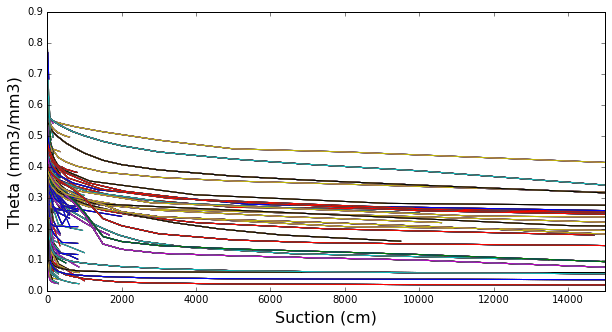

In [115]:
fig = plt.figure(figsize=(10,5))

for soil in Data.index:
    plt.plot(Data.ix[soil,'preshead'],Data.ix[soil,'theta'])
plt.xlim(0,15000)
plt.ylabel('Theta (mm3/mm3)',fontsize=16)
plt.xlabel('Suction (cm)',fontsize=16)

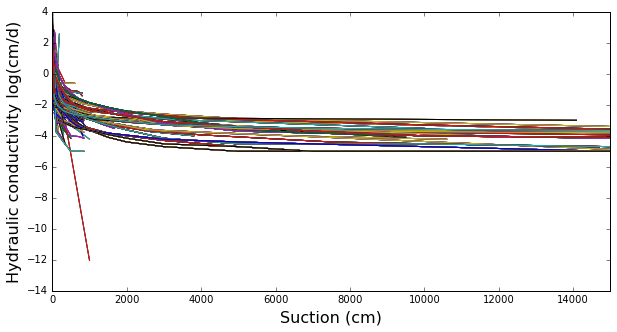

In [116]:
fig = plt.figure(figsize=(10,5))

for soil in Data.index:
    plt.plot(Data.ix[soil,'preshead'],np.log10(Data.ix[soil,'conductivity']))
plt.xlim(0,15000)
plt.ylabel('Hydraulic conductivity log(cm/d)',fontsize=16)
plt.xlabel('Suction (cm)',fontsize=16)


## Quite alot of soils have insufficient range in their k and theta measurements to be useful.  
## Filter out anything that has a narrow range of measurements

In [117]:
#This cell throws a copy slice error and takes a long time to run, but it still does what is intended.
Data.ix[:,'FullSet'] = 'false'
for soil in Data.index:
    if Data.ix[soil,'preshead'].max() >= 15000 and Data.ix[soil,'preshead'].min() <= 100:
        Data.ix[soil,'FullSet'] = 'true'

In [118]:
SetFilter = Data.ix[:,'FullSet'] == 'true'

In [119]:
FullData = Data.ix[SetFilter,:].copy()

### Convert conductivity data to mm/h and potentials to mmH2O

In [223]:
condcmd = FullData.ix[:,'conductivity']
prescm = FullData.ix[:,'preshead']
FullData.ix[:,'conductivity'] = condcmd*10/24
FullData.ix[:,'preshead'] = prescm * 10

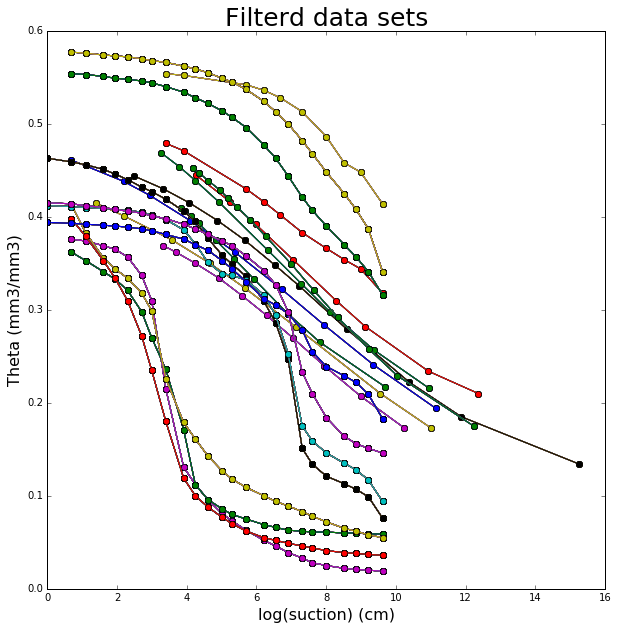

In [121]:
fig = plt.figure(figsize=(10,10))

for soil in FullData.index:
    plt.plot(np.log(FullData.ix[soil,'preshead']),FullData.ix[soil,'theta'],'o-')
plt.ylabel('Theta (mm3/mm3)',fontsize=16)
plt.xlabel('log(suction) (cm)',fontsize=16)
plt.title('Filterd data sets', fontsize=25)


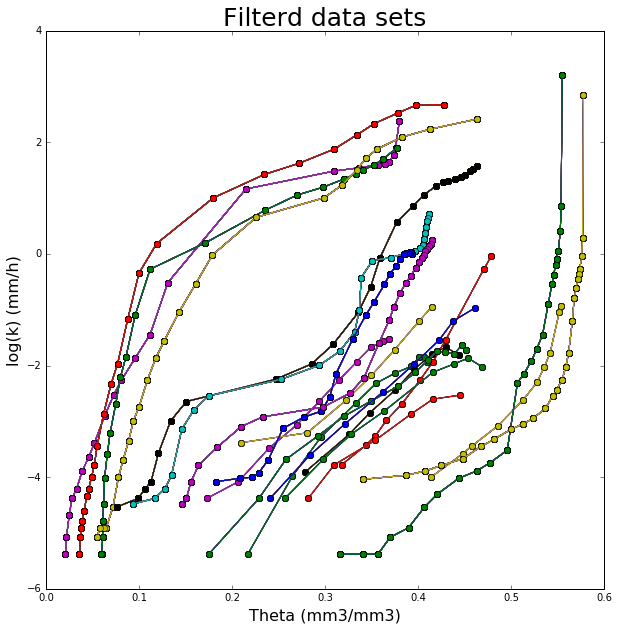

In [122]:
fig = plt.figure(figsize=(10,10))

for soil in FullData.index:
    plt.plot(FullData.ix[soil,'theta'],np.log10(FullData.ix[soil,'conductivity']),'o-')
plt.xlabel('Theta (mm3/mm3)',fontsize=16)
plt.ylabel('log(k) (mm/h)',fontsize=16)
plt.title('Filterd data sets', fontsize=25)

## Now we have a data set we can work with lets calculate some things

### Index bits for a start

In [123]:
FullData.sort_values(by=['code','preshead'],inplace=True)

In [124]:
FullData.ix[:,'IntCode']=[x for x in range(FullData.index.size)]

In [125]:
FullData.ix[:,'SampleCode'] = 0

In [126]:
StartCode = 0
for x in FullData.index:
    code = range(StartCode,StartCode + FullData.ix[x,'SampleCode'].size)
    Soil = FullData.ix[x,'SampleCode'] = code

## Set up some arbitary pore compartments 

### assuming the largest compartments upper diameter is that of the lowest measured pressure and the lower diameter of the smallest pore is zero

In [127]:
FullData.set_index('IntCode',inplace=True)

In [225]:
# UpperDiameter units = um
FullData.ix[:,'UpperDiameter'] = 30000/FullData.ix[:,'preshead']

In [226]:
FullData.ix[:,'LowerDiameter'] = 0

In [227]:
def LowerDia(x):
    if x == 348:
        ret_val = 0
    else:
        if FullData.ix[x,'code'] != FullData.ix[x+1,'code']:
            ret_val = 0
        else:
            ret_val = FullData.ix[x+1,'UpperDiameter']
        return ret_val

In [228]:
# LowerDiameter units = um
FullData.ix[:,'LowerDiameter'] = [LowerDia(x) for x in range(FullData.index.size)]

In [229]:
def thetaLower(x):
    if x == 348:
        ret_val = 0
    else:
        if FullData.ix[x,'code'] != FullData.ix[x+1,'code']:
            ret_val = 0
        else:
            ret_val = FullData.ix[x+1,'theta']
    return ret_val

In [230]:
FullData.ix[:,'ThetaLower'] = [thetaLower(x) for x in range(FullData.index.size)]

### The radius of each more compartment is the mean of its upper and lower diameters

In [231]:
# PoreRadius units = um
FullData.ix[:,'PoreRadius'] = np.add(FullData.ix[:,'UpperDiameter'],FullData.ix[:,'LowerDiameter'])/4

### The volume of each pore compartment is derived from theta at its upper and lower boundary

In [232]:
# volume units = mm3/mm3
FullData.ix[:,'Volume'] = FullData.ix[:,'theta'] - FullData.ix[:,'ThetaLower']

### The area of individual pore columns in each compartment is calcualted from its radius

In [233]:
# Area units = um2
FullData.ix[:,'Area'] = np.pi * np.power(FullData.ix[:,'PoreRadius'],2)

### The number of pore columns in each compartment is calculated from its radius and the horizontal area of the compartment, assumed to be equivelent to its pore volume (mm3/mm3)

In [234]:
# Number units = /m2
FullData.ix[:,'Number'] = np.divide(FullData.ix[:,'Volume'],np.divide(FullData.ix[:,'Area'], 1000000000000))

## Now we have all the bits in place to calculate the k curve of the soil from its theta curve.  

This is done as following Arya etal 1999

For each pore compartment we estimate a volumetric flow rate per pore column as:

$FlowRate = Cflow * Radius^{3.6}$

The the volumetric flow through that pore compartment as:

$VolumetricFlow = FlowRate * Number$

Then the hydraulic conductivity at a given suction is calculated by summing the conductivity of the pores that are water filled at and below that suction of each pore boundary

In [138]:
FullData.ix[:,'HydraulicConductivity'] = 0

### Calculate the hydraulic flow rate through a single pore compartment from pore size and number

In [235]:
def flowRate(Radius):
    Cflow = 3e-11
    Xflow = 4.0
    return Cflow * np.power(Radius,Xflow) 

In [236]:
# FlowRate units = mm3/s
FullData.ix[:,'FlowRate'] =  [flowRate(FullData.ix[x,'PoreRadius']) for x in range(FullData.index.size)]

In [237]:
# VolumetricFlow units = mm3/s/m2
FullData.ix[:,'VolumetricFlow'] =  FullData.ix[:,'FlowRate'] * FullData.ix[:,'Number']

In [238]:
# Capillarity units = mm/h
FullData.ix[:,'Capillarity'] = FullData.ix[:,'VolumetricFlow']/1e6*3600
#divide by 1 million to convert mm3 to l/m2, multiply by 3600

### Accumulate flow rates for current and smaller pores to calculate k at tension when this pore if full (i.e k curve)

In [239]:
def AccumCond(x):
    if x == 348:
        ret_val = FullData.ix[x,'Capillarity']
    else:
        if FullData.ix[x,'code'] != FullData.ix[x+1,'code']:
            ret_val = FullData.ix[x,'Capillarity']
        else:
            ret_val = FullData.ix[x,'Capillarity'] + FullData.ix[x+1,'HydraulicConductivity']
    return ret_val

In [240]:
for x in reversed(range(FullData.index.size)):
    FullData.ix[x,'HydraulicConductivity'] = AccumCond(x)

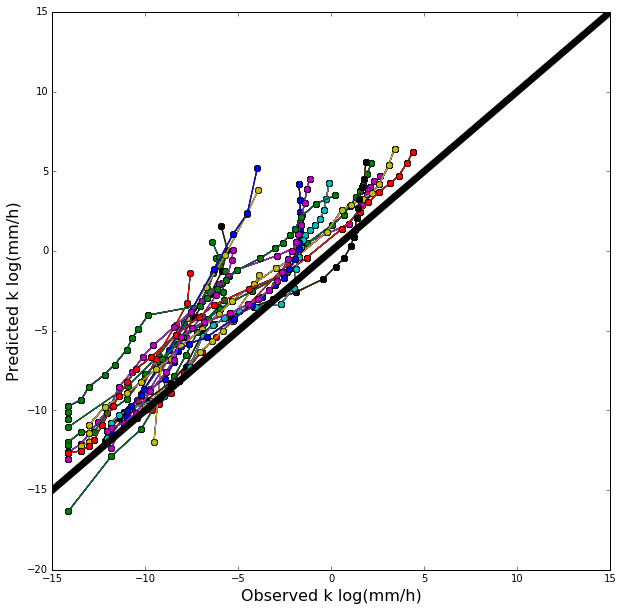

In [241]:
GraphData = FullData.set_index('code')

fig = plt.figure(figsize=(10,10))

for soil in GraphData.index:
    plt.plot(np.log(GraphData.ix[soil,'conductivity']),np.log(GraphData.ix[soil,'HydraulicConductivity']),'o-')
plt.ylabel('Predicted k log(mm/h)',fontsize=16)
plt.xlabel('Observed k log(mm/h)',fontsize=16)
plt.plot([-15,15],[-15,15],linewidth=7)

Cflow = plt.figure(figsize=(10,5))

## Now we have fitted the parameters for the moisture release curve lets see if we can feed the observed theta data through the spline method and see if our model will reproduce the conductivity data

In [213]:
PoreBounds = [ 3000, 1194, 475, 189, 75, 30, 8.6, 2.47, 0.707, 0.202, 0.0005 ]

BoundPSI =  np.divide(-3000,PoreBounds)

In [214]:
def ThetaCurve(SAT,DUL,LL15,PSI):

    ##Set up parameters for spline
    psid = -100
    psi0 = -0.6e7
    psi_ll15 = -15000.0;

    DELk = [0] * 4
    DELk[0] = (DUL - (SAT+0.000000000001)) / (np.log10(-psid))#Tiny amount added to Sat so in situations where DUL = SAT this function returns a non zero value
    DELk[1] = (LL15 - DUL) / (np.log10(-psi_ll15) - np.log10(-psid))
    DELk[2] = -LL15 / (np.log10(-psi0) - np.log10(-psi_ll15))
    DELk[3] = -LL15 / (np.log10(-psi0) - np.log10(-psi_ll15))

    Mk = [0] * 4
    Mk[0] = 0.0
    Mk[1] = (DELk[0] + DELk[1]) / 2.0
    Mk[2] = (DELk[1] + DELk[2]) / 2.0
    Mk[3] = DELk[3]

    # First bit might not be monotonic so check and adjust
    alpha = Mk[0] / DELk[0]
    beta = Mk[1] / DELk[0]
    phi = alpha - (np.power(2.0 * alpha + beta - 3.0, 2.0) / (3.0 * (alpha + beta - 2.0)));
    if (phi <= 0):
        tau = 3.0 / np.sqrt(alpha * alpha + beta * beta)
        Mk[0] = tau * alpha * DELk[0]
        Mk[1] = tau * beta * DELk[0]

    M0 = [0] * 5
    M1 = [0] * 5
    Y0 = [0] * 5
    Y1 = [0] * 5

    M0[0] = 0.0;
    M1[0] = 0.0;
    Y0[0] = SAT;
    Y1[0] = SAT;

    M0[1] = Mk[0] * (np.log10(-psid) - 0.0);
    M1[1] = Mk[1] * (np.log10(-psid) - 0.0);
    Y0[1] = SAT;
    Y1[1] = DUL;

    M0[2] = Mk[1] * (np.log10(-psi_ll15) - np.log10(-psid));
    M1[2] = Mk[2] * (np.log10(-psi_ll15) - np.log10(-psid));
    Y0[2] = DUL;
    Y1[2] = LL15;

    M0[3] = Mk[2] * (np.log10(-psi0) - np.log10(-psi_ll15));
    M1[3] = Mk[3] * (np.log10(-psi0) - np.log10(-psi_ll15));
    Y0[3] = LL15;
    Y1[3] = 0.0;

    M0[4] = 0.0;
    M1[4] = 0.0;
    Y0[4] = 0.0;
    Y1[4] = 0.0;

    Thetas = []
    Test = []
    for psi in PSI:
        if (psi >= -1.0):
            i = 0;
            t = 0.0;
        elif (psi > psid):
            i = 1;
            t = (np.log10(-psi) - 0.0) / (np.log10(-psid) - 0.0);
        elif (psi > psi_ll15):
            i = 2;
            t = (np.log10(-psi) - np.log10(-psid)) / (np.log10(-psi_ll15) - np.log10(-psid));
        elif (psi > psi0):
            i = 3;
            t = (np.log10(-psi) - np.log10(-psi_ll15)) / (np.log10(-psi0) - np.log10(-psi_ll15));
        else:
            i = 4;
            t = 0.0;

        tSqr = t * t;
        tCube = tSqr * t;
        theta = (2 * tCube - 3 * tSqr + 1) * Y0[i] + (tCube - 2 * tSqr + t) * M0[i]\
                + (-2 * tCube + 3 * tSqr) * Y1[i] + (tCube - tSqr) * M1[i];
        Thetas.append(min(theta, SAT))#When Sat and DUL are very close, spline can produce number greater that sat
    return Thetas

In [215]:
BoundrySuction = [0,0,0.4,0.4,0.8,0.8,1.2,1.2,1.6,1.6,2,2,2.54,2.54,3.085,3.085,3.6275,3.6275,4.17,4.17,6.77,6.77]
BoundryMarkers = [-0.1,10000,10000,-0.1,-0.1,10000,10000,-0.1,-0.1,10000,10000,-0.1,-0.1,10000,10000,-0.1,-0.1,10000,10000,-0.1,-0.1,10000]

In [216]:
def MakeConductivityFrame(SAT,DUL,LL15):
    # DiaUpper Units = um
    ConductivityFrame = pd.DataFrame(index = range(11), columns = ['DiaUpper'], data = PoreBounds)
    # DiaLower Units = um
    for x in ConductivityFrame.index:
        try:
            ConductivityFrame.ix[x,'DiaLower'] = ConductivityFrame.ix[x+1,'DiaUpper']
        except:
            ConductivityFrame.ix[x,'DiaLower'] = 0
    # PsiUpper units = cmH2O
    ConductivityFrame.ix[:,'PsiUpper'] = np.divide(-3000,ConductivityFrame.ix[:'DiaUpper']) 
    # PsiLower units = cmH2O
    for x in ConductivityFrame.index:
        try:
            ConductivityFrame.ix[x,'PsiLower'] = ConductivityFrame.ix[x+1,'PsiUpper']
        except:
            ConductivityFrame.ix[x,'PsiLower'] = 0
    # ThetaUpper Units = mm3/mm3
    ConductivityFrame.ix[:,'ThetaUpper'] = ThetaCurve(SAT,DUL,LL15,ConductivityFrame.ix[:,'PsiUpper'])
    # ThetaLower Units = mm3/mm3
    ConductivityFrame.ix[:,'ThetaLower'] = ThetaCurve(SAT,DUL,LL15,ConductivityFrame.ix[:,'PsiLower'])  
    # Volume Units = mm3/mm3
    ConductivityFrame.ix[:,'Volume'] = ConductivityFrame.ix[:,'ThetaUpper'] - ConductivityFrame.ix[:,'ThetaLower']
    # Radius units = um
    ConductivityFrame.ix[:,'Radius'] = (ConductivityFrame.ix[:,'DiaUpper'] + ConductivityFrame.ix[:,'DiaLower'])/4 
    # Area units = um2
    ConductivityFrame.ix[:,'Area'] = np.pi * np.power(ConductivityFrame.ix[:,'Radius'],2)
    # Number units = /m
    ConductivityFrame.ix[:,'Number'] = ConductivityFrame.ix[:,'Volume']/(ConductivityFrame.ix[:,'Area']/1000000000000)
    # Xflow is unitless
    ConductivityFrame.ix[:,'Xflow'] = 1.6 + 2 * np.exp(ConductivityFrame.ix[:,'Radius']*-0.008)
    # PoreFlowRate units = cm3/s
    ConductivityFrame.ix[:,'PoreFlowRate'] = 0.0005 * np.power((ConductivityFrame.ix[:,'Radius']/10000),ConductivityFrame.ix[:,'Xflow'])
    # VolumetricFlowRate units = cm3/s/m2
    ConductivityFrame.ix[:,'VolumetricFlowRate'] = ConductivityFrame.ix[:,'PoreFlowRate'] * ConductivityFrame.ix[:,'Number']
    # Capilalarity units = mm/h
    ConductivityFrame.ix[:,'Capillarity'] = ConductivityFrame.ix[:,'VolumetricFlowRate']/1000*3600
    ConductivityFrame.ix[:,'Sorbtivity'] = np.sqrt(((7.4/ConductivityFrame.ix[:,'Radius']*1000) * ConductivityFrame.ix[:,'Capillarity'])/0.5)
    ConductivityFrame.ix[:,'Sorption'] = 0.5 * ConductivityFrame.ix[:,'Sorbtivity'] * np.power(1,-0.5)  
    ConductivityFrame.ix[:,'Kin'] = ConductivityFrame.ix[:,'Capillarity'] + ConductivityFrame.ix[:,'Sorption'] 
    ConductivityFrame.ix[:,'CumCapil'] = 0
    for x in reversed(ConductivityFrame.index):
        if x < 10:
            ConductivityFrame.ix[x,'CumCapil'] = ConductivityFrame.ix[x+1,'CumCapil'] + ConductivityFrame.ix[x,'Capillarity']
    ConductivityFrame.ix[:,'CumSorp'] = 0
    for x in reversed(ConductivityFrame.index):
        if x < 10:
            ConductivityFrame.ix[x,'CumSorp'] = ConductivityFrame.ix[x+1,'CumSorp'] + ConductivityFrame.ix[x,'Sorbtivity']
    ConductivityFrame.ix[:,'Cumkin'] = ConductivityFrame.ix[:,'CumCapil'] + ConductivityFrame.ix[:,'CumSorp']
    return ConductivityFrame

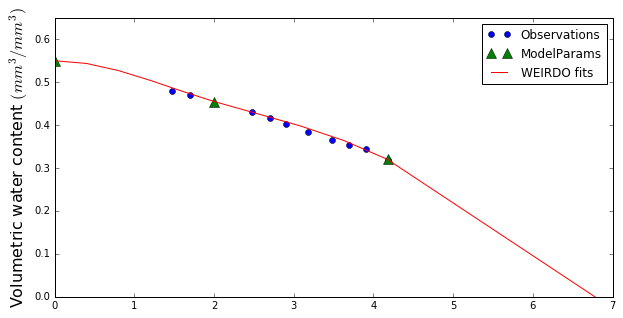

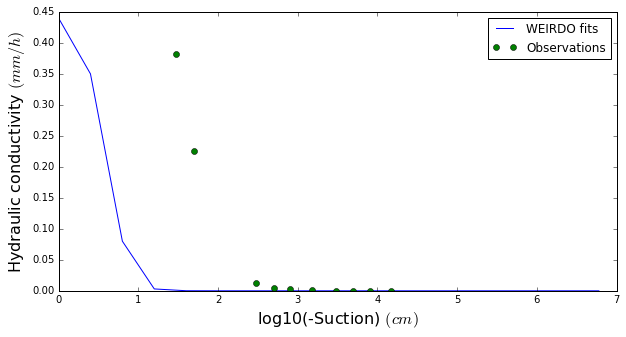

In [220]:
Set = '2360'
FitSAT = 0.55
FitDUL = 0.455
FitLL = 0.32

fig = plt.figure(figsize=(10,5))
plt.plot(np.log10(GraphData.ix[Set,'preshead']),GraphData.ix[Set,'theta'],'o',label = 'Observations')
plt.plot(np.log10([1,100,15000]),[FitSAT,FitDUL,FitLL],'^',markersize = 10,label = 'ModelParams')
plt.plot(np.log10(-BoundPSI),ThetaCurve(FitSAT,FitDUL,FitLL,BoundPSI),label = 'WEIRDO fits')
plt.ylim(0,0.65)
plt.ylabel(r'Volumetric water content $(mm^3/mm^3)$',fontsize=16)
plt.legend()

FitFrame = MakeConductivityFrame(FitSAT,FitDUL,FitLL)

ymax = 10
fig = plt.figure(figsize=(10,5))
plt.plot(np.log10(-FitFrame.ix[:,'PsiUpper']),FitFrame.ix[:,'CumCapil'],label = 'WEIRDO fits')
plt.plot(np.log10(GraphData.ix[Set,'preshead']),GraphData.ix[Set,'conductivity']*10/24,'o', label = 'Observations')
plt.xlabel(r'log10(-Suction) $(cm)$',fontsize=16)
plt.ylabel(r'Hydraulic conductivity $(mm/h)$',fontsize=16)
plt.legend()

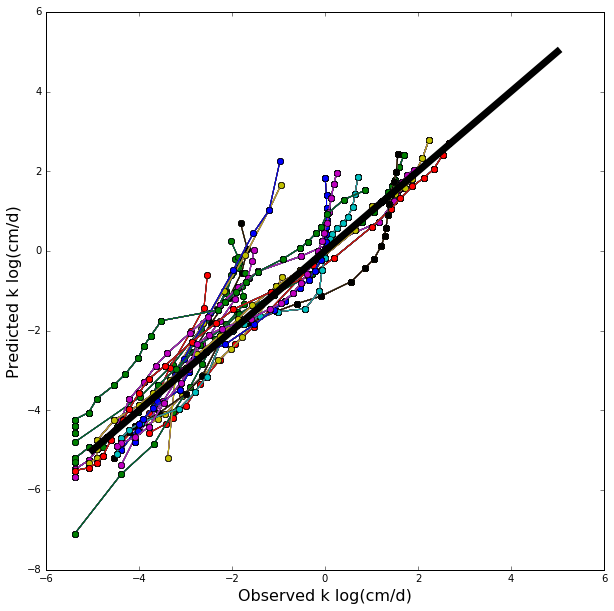

In [204]:
FullData.ix[:,'HydraulicConductivity'] = 0

# Calculate the hydraulic flow rate through a single pore compartment from pore size and number
def flowRate(Radius):
    Cflow = 3e-11
    Xflow = 4.0
    return Cflow * np.power(Radius,Xflow)
# FlowRate units = mm3/s
FullData.ix[:,'FlowRate'] =  [flowRate(FullData.ix[x,'PoreRadius']) for x in range(FullData.index.size)]
# VolumetricFlow units = mm3/s/m2
FullData.ix[:,'VolumetricFlow'] =  FullData.ix[:,'FlowRate'] * FullData.ix[:,'Number']
# Capillarity units = mm/h
FullData.ix[:,'Capillarity'] = FullData.ix[:,'VolumetricFlow']/1e6*3600
#Accumulate flow rates for current and smaller pores to calculate k at tension when this pore if full (i.e k curve)
def AccumCond(x):
    if x == 348:
        ret_val = FullData.ix[x,'Capillarity']
    else:
        if FullData.ix[x,'code'] != FullData.ix[x+1,'code']:
            ret_val = FullData.ix[x,'Capillarity']
        else:
            ret_val = FullData.ix[x,'Capillarity'] + FullData.ix[x+1,'HydraulicConductivity']
    return ret_val
for x in reversed(range(FullData.index.size)):
    FullData.ix[x,'HydraulicConductivity'] = AccumCond(x)
GraphData = FullData.set_index('code')

fig = plt.figure(figsize=(10,10))

for soil in GraphData.index:
    plt.plot(np.log10(GraphData.ix[soil,'conductivity']),np.log10(GraphData.ix[soil,'HydraulicConductivity']),'o-')
plt.ylabel('Predicted k log(cm/d)',fontsize=16)
plt.xlabel('Observed k log(cm/d)',fontsize=16)
plt.plot([-5,5],[-5,5],linewidth=7)

Cflow = plt.figure(figsize=(10,5))

## It appears that assuming Cflow increases with pore radius works OK??

In [188]:
GraphData.ix['2360',:]#'conductivity']

,preshead,theta,conductivity,FullSet,SampleCode,UpperDiameter,LowerDiameter,ThetaLower,PoreRadius,Volume,Area,Number,HydraulicConductivity,FlowRate,VolumetricFlow,Capillarity
code,,,,,,,,,,,,,,,,
2360,30.0,0.479,0.916667,true,0,100.000,60.000,0.471,40.00000,0.008,5026.548246,1.591549e+06,0.524457,5.408420e-08,0.086078,0.309880
2360,50.0,0.471,0.541667,true,1,60.000,10.000,0.430,17.50000,0.041,962.112750,4.261455e+07,0.214577,1.361452e-09,0.058018,0.208864
2360,300.0,0.430,0.029167,true,2,10.000,6.000,0.416,4.00000,0.014,50.265482,2.785212e+08,0.005714,3.299549e-12,0.000919,0.003308
2360,500.0,0.416,0.011667,true,3,6.000,3.750,0.402,2.43750,0.014,18.665478,7.500478e+08,0.002405,4.942226e-13,0.000371,0.001334
2360,800.0,0.402,0.005417,true,4,3.750,2.000,0.383,1.43750,0.019,6.491807,2.926766e+09,0.001071,6.798120e-14,0.000199,0.000716
2360,1500.0,0.383,0.002083,true,5,2.000,1.000,0.366,0.75000,0.017,1.767146,9.620032e+09,0.000355,6.132076e-15,0.000059,0.000212
2360,3000.0,0.366,0.001042,true,6,1.000,0.600,0.354,0.40000,0.012,0.502655,2.387324e+10,0.000142,6.153582e-16,0.000015,0.000053
2360,5000.0,0.354,0.000542,true,7,0.600,0.375,0.344,0.24375,0.010,0.186655,5.357484e+10,0.000089,1.016431e-16,0.000005,0.000020
2360,8000.0,0.344,0.000375,true,8,0.375,0.200,0.318,0.14375,0.026,0.064918,4.005048e+11,0.000070,1.500447e-17,0.000006,0.000022


In [109]:
GraphData.columns

Index([             u'preshead',                 u'theta',
                u'conductivity',               u'FullSet',
                  u'SampleCode',         u'UpperDiameter',
               u'LowerDiameter',            u'ThetaLower',
                  u'PoreRadius',                u'Volume',
                        u'Area',                u'Number',
       u'HydraulicConductivity',              u'FlowRate',
              u'VolumetricFlow',           u'Capillarity'],
      dtype='object')